In [1]:
#This program fits the O-PPAC data onto a FCNN model
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, metrics, Model
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import numpy as np
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py
import datetime

In [2]:
dataset = h5py.File('simu_HDF.h5', 'r') #load data
num_diodes = dataset['Num_diodes'][...] #separate the data into each key within the data file
x_pos = (dataset['Xpos'][...])/100
y_pos = (dataset['Ypos'][...])/100
histgrid = dataset['histgrid'][...]
histgrid = histgrid[:-1,:,:] #redefine the shape and size of histgrid by removing the last xy position "342" because it is bad
output = np.vstack((x_pos,y_pos)) #define new, single variable for x and y position
output = np.transpose(output) #original definition was sideways, so we transposed it

where_are_NaNs = isnan(histgrid) #removes any NaN values within histgrid; shouldn't be a problem with 342 removed
histgrid[where_are_NaNs] = 0

dataset.close()

In [3]:
def data_compile(histdata):
    data = []  #creates empty arrays for data and labels
    labels = []
    for i in range(histdata.shape[0]):
        for j in range(1,histdata.shape[2]):
            data.append(histdata[i,0:132,j]) #puts histgrid data inside of "data"
            labels.append(output[i]) #puts xy pos into "labels"
    return(np.array(data),np.array(labels))

all_data, all_labels = data_compile(histgrid)

#to make sure everything is the correct shape
print(all_data.shape)
print(all_labels.shape)

(341000, 132)
(341000, 2)


In [4]:
all_data = normalize(all_data,axis = 1)
print(np.max(all_data))

1.0


In [34]:
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, test_size=0.2,shuffle=True)
#splits training and test data for the FCNN; 20% set aside for testing

In [35]:
train_data.ndim

2

In [36]:
train_data.shape

(272800, 132)

In [37]:
train_data[0]

array([0.00792796, 0.00396398, 0.09909951, 0.09117155, 0.23783883,
       0.24973077, 0.12288339, 0.07135165, 0.        , 0.00396398,
       0.        , 0.00396398, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00396398, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00396398,
       0.        , 0.        , 0.        , 0.00792796, 0.00396398,
       0.01189194, 0.15063126, 0.42018193, 0.3448663 , 0.03567582,
       0.00396398, 0.        , 0.00396398, 0.        , 0.        ,
       0.00792796, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00396398, 0.        ,
       0.        , 0.        , 0.00792796, 0.        , 0.05153175,
       0.13873932, 0.15063126, 0.23783883, 0.2219829 , 0.08324

In [38]:
#early stopping mechanism; can increase amount of time before stopping by increasing patience
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [39]:
#Fully connected neural network
#the "layers" are the dense hidden layers which are fully connected
#first number changes the nodes, 2nd is the activation function, (first line has number of inputs as well)

FCNN_model = tf.keras.Sequential()
FCNN_model.add(layers.Dense(256, activation='relu', input_shape = [132]))
FCNN_model.add(layers.Dense(256, activation = 'relu'))
#FCNN_model.add(layers.Dense(128, activation = 'relu'))
#FCNN_model.add(layers.Dense(128, activation = 'relu'))
#FCNN_model.add(layers.Dropout(0.1))
FCNN_model.add(layers.Dense(2, activation = 'linear'))

In [40]:
#compiles the FCNN and includes the learning rate as well
FCNN_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss = 'mse', 
              metrics=['mae', 'mse'])

In [14]:
FCNN_history = FCNN_model.fit(train_data, train_labels,
                    epochs=20,
                    batch_size = 32,
                    #callbacks = [callback],
                    validation_split = 0.3 
                    )

Epoch 1/100
5968/5968 [==============================] - 20s 3ms/step - loss: 20.1811 - mae: 2.5296 - mse: 20.1811 - val_loss: 4.9441 - val_mae: 1.6355 - val_mse: 4.9441
Epoch 2/100
5968/5968 [==============================] - 18s 3ms/step - loss: 2.4874 - mae: 1.1340 - mse: 2.4874 - val_loss: 2.4625 - val_mae: 1.1431 - val_mse: 2.4625
Epoch 3/100
5968/5968 [==============================] - 17s 3ms/step - loss: 1.7038 - mae: 0.9379 - mse: 1.7038 - val_loss: 1.6976 - val_mae: 0.9418 - val_mse: 1.6976
Epoch 4/100
5968/5968 [==============================] - 15s 3ms/step - loss: 1.3623 - mae: 0.8308 - mse: 1.3623 - val_loss: 1.2480 - val_mae: 0.8034 - val_mse: 1.2480
Epoch 5/100
5968/5968 [==============================] - 16s 3ms/step - loss: 1.1581 - mae: 0.7607 - mse: 1.1581 - val_loss: 1.0557 - val_mae: 0.7243 - val_mse: 1.0557
Epoch 6/100
5968/5968 [==============================] - 17s 3ms/step - loss: 1.0171 - mae: 0.7107 - mse: 1.0171 - val_loss: 0.8975 - val_mae: 0.6542 - val_ms

KeyboardInterrupt: 

In [16]:
plt.plot(FCNN_history.history['loss'], label='loss')
plt.plot(FCNN_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title("FCNN O-PPAC Loss Curve, Dropout 0, 2 Dense 256 Node, RMSprop 0.001, MSE, linear activation")

NameError: name 'FCNN_history' is not defined

In [455]:
result = FCNN_model.evaluate(test_data, test_labels, verbose=2)

1894/1894 - 2s - loss: 1.2173 - mae: 0.5675 - mse: 1.2173


In [456]:
predictions = FCNN_model.predict(test_data)

In [457]:
predictions[0]

array([-23.86193 ,   8.256446], dtype=float32)

In [458]:
x_pred = predictions[:,0]
y_pred = predictions[:,1]


x_test1 = [i[0] for i in test_labels]
y_test1 = [i[1] for i in test_labels]

x_test = np.array(x_test1)
y_test = np.array(y_test1)

x_test_error = x_test + 45
y_test_error = y_test + 45
x_pred_error = x_pred + 45
y_pred_error = y_pred + 45

x_test[0]
y_test[0]


print(np.min(y_pred))
print(np.min(y_pred_error))

-43.471977
1.5280228


In [17]:
new_x_labels = []
for i in range(x_test.shape[0]):
    new_x_labels.append([x_test[i]])
np.array(new_x_labels)
new_x_labels[2]

a = plt.axes(aspect='equal')
plt.scatter(new_x_labels, x_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title("FCNN O-PPAC X Predictions vs True X Values")

NameError: name 'x_test' is not defined

Text(0.5, 1.0, 'FCNN O-PPAC Y Predictions vs True Y Values')

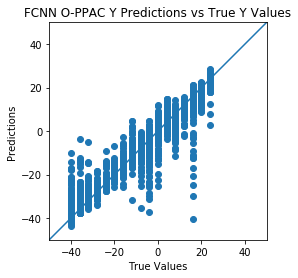

In [461]:
new_y_labels = []
for i in range(y_test.shape[0]):
    new_y_labels.append([y_test[i]])
np.array(new_y_labels)
new_y_labels[2]

a = plt.axes(aspect='equal')
plt.scatter(new_y_labels, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title("FCNN O-PPAC Y Predictions vs True Y Values")

In [439]:
x_train = [i[0] for i in train_labels]
y_train = [i[1] for i in train_labels]


#print(x_train)
print(max(x_train))
print(min(x_train))
print(len(x_train))

40.0
-40.0
242400


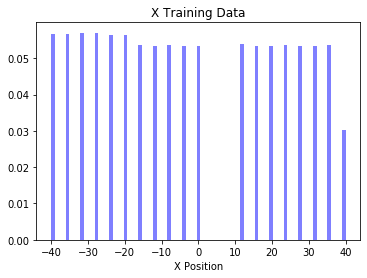

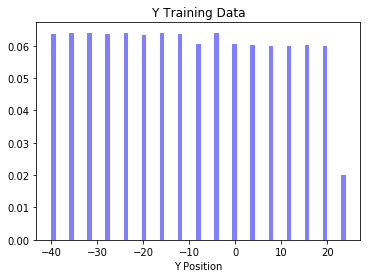

In [440]:
num_bins_x = 81
# the histogram of the data
n, bins, patches = plt.hist(x_train, num_bins_x, density=1, facecolor='blue', alpha=0.5)

plt.xlabel('X Position')

plt.title(r'X Training Data')
# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()



num_bins_y = 65
# the histogram of the data
n, bins, patches = plt.hist(y_train, num_bins_y, density=1, facecolor='blue', alpha=0.5)

plt.xlabel('Y Position')

plt.title(r'Y Training Data')
# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()